### Simple ephemeris generation and orbit propagation with sims_movingObjects (and OOrb's python bindings) ###

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from lsst.sims.movingObjects import Orbits
from lsst.sims.movingObjects import PyOrbEphemerides

In [2]:
# Read orbits.
orbitfile = 'neos_100.s3m'
orbits = Orbits()
orbits.readOrbits(orbitfile)
## if you have orbits in a dataframe already .. 
## see also orbits.setOrbits()

# See the internal data structure .. (pandas dataframe)
orbits.orbits[0:3]

,objId,otype,q,e,inc,Omega,argPeri,tPeri,H,g,epoch,model,sed_filename
0,S1000000,S3M,3.01822,0.05208,22.56035,211.00286,335.42134,57801.64493,14.20,0.15,57231.0,V150728,C.dat
1,S1000001,S3M,2.10974,0.07518,4.91571,209.40298,322.66447,56722.78779,20.57,0.15,57231.0,V150728,S.dat
2,S1000002,S3M,2.80523,0.07777,1.24945,112.52284,139.86858,56406.44304,14.65,0.15,57231.0,V150728,S.dat


In [3]:
# The actual orbits are checked to see if they contain required columns: 
for orbit_type in orbits.dataCols:
    print(orbit_type, orbits.dataCols[orbit_type])

COM ['objId', 'q', 'e', 'inc', 'Omega', 'argPeri', 'tPeri', 'epoch', 'H', 'g', 'sed_filename']
KEP ['objId', 'a', 'e', 'inc', 'Omega', 'argPeri', 'meanAnomaly', 'epoch', 'H', 'g', 'sed_filename']
CAR ['objId', 'x', 'y', 'z', 'xdot', 'ydot', 'zdot', 'epoch', 'H', 'g', 'sed_filename']


Note that all angles should be in degrees and all times should be in MJD. Epochs are assumed to be TT.

We then use the Orbits to generate ephemerides, using PyOrbEphemerides. 

The idea is that the Orbits class tracks some requirements about orbital parameters, and adds additional values like the g or sed_filename values (if required), while PyOrbEphemerides provides an easier (and separate) interface to OpenOrb. By keeping PyOrbEphemerides separate, ephemeris generation and propagation could be handled by a different program if desired. 

In [4]:
# Set up pyoorb interface/object.
planetaryEphFile = os.path.join(os.getenv('OORB_DATA'), 'DE430.dat')
oorb = PyOrbEphemerides(planetaryEphFile)

In [5]:
# Pass the Orbits object to the Oorb object. 
# Now oorb will keep those orbits internally. 
# It can transform them to other formats and/or propagate to other epochs.
# Internally, it stores them in a different format.
oorb.setOrbits(orbits)

Example of ephemeris generation.

In [6]:
# times for ephemerides.
tstart = orbits.orbits.epoch.iloc[0] 
times = np.arange(tstart, tstart + 30, 0.5)

In [7]:
ephs = oorb.generateEphemerides(times, obscode='I41', ephMode='nbody', ephType='basic')

In [8]:
# Values returned in ephType = basic:
ephs.dtype.names

('time',
 'ra',
 'dec',
 'dradt',
 'ddecdt',
 'phase',
 'solarelon',
 'helio_dist',
 'geo_dist',
 'magV',
 'trueAnomaly',
 'velocity')

In [9]:
# Shape of ephemeris array: there were 100 objects, so these are per object, and then per time.
ephs.shape

(100, 60)

In [10]:
ephs[0]['time']

array([57231. , 57231.5, 57232. , 57232.5, 57233. , 57233.5, 57234. ,
       57234.5, 57235. , 57235.5, 57236. , 57236.5, 57237. , 57237.5,
       57238. , 57238.5, 57239. , 57239.5, 57240. , 57240.5, 57241. ,
       57241.5, 57242. , 57242.5, 57243. , 57243.5, 57244. , 57244.5,
       57245. , 57245.5, 57246. , 57246.5, 57247. , 57247.5, 57248. ,
       57248.5, 57249. , 57249.5, 57250. , 57250.5, 57251. , 57251.5,
       57252. , 57252.5, 57253. , 57253.5, 57254. , 57254.5, 57255. ,
       57255.5, 57256. , 57256.5, 57257. , 57257.5, 57258. , 57258.5,
       57259. , 57259.5, 57260. , 57260.5])

In [11]:
ephs = oorb.generateEphemerides(times, obscode='I41', ephMode='nbody', ephType='full')

In [12]:
# Values returned with ephtype = full:
ephs.dtype.names

('time',
 'ra',
 'dec',
 'dradt',
 'ddecdt',
 'phase',
 'solarelon',
 'helio_dist',
 'geo_dist',
 'magV',
 'pa',
 'topo_lon',
 'topo_lat',
 'opp_topo_lon',
 'opp_topo_lat',
 'helio_lon',
 'helio_lat',
 'opp_helio_lon',
 'opp_helio_lat',
 'topo_obj_alt',
 'topo_solar_alt',
 'topo_lunar_alt',
 'lunar_phase',
 'lunar_dist',
 'helio_x',
 'helio_y',
 'helio_z',
 'helio_dx',
 'helio_dy',
 'helio_dz',
 'obs_helio_x',
 'obs_helio_y',
 'obs_helio_z',
 'trueAnom',
 'velocity')

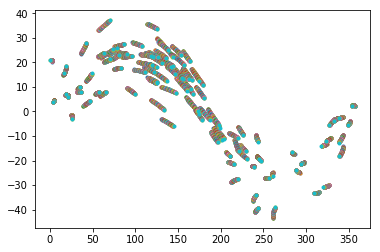

In [13]:
# RA and Dec of all objects at each time:
for i in range(len(ephs[0])):
    ra = ephs[:,i]['ra']
    dec = ephs[:,i]['dec']
    plt.plot(ra, dec, marker='.', linestyle='')